# Advanced NLP Workshop

In this workshop, you will learn a number of advanced NLP techniques, with exercises based on a real-world dataset of tweets on #Telstra and #Optus.

**Installing required libraries.**

Install pyLDAvis library for interactive topic visualization dashboard.

In [34]:
!pip install pyLDAvis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load libraries.

In [35]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load data

Load the two datasets (Download from LMS)

In [36]:
df_telstra = pd.read_excel("tp7_telco.xlsx", sheet_name='telstra')
df_optus = pd.read_excel("tp7_telco.xlsx", sheet_name='optus')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# display the column names of the datasets
df_optus.columns

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['date', 'content', 'likes', 'retweets', 'authorID', 'name', 'gender',
       'followers', 'following', 'nTweets', 'location', 'tweets', 'day'],
      dtype='object')

In [38]:
df_telstra.columns

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['date', 'content', 'likes', 'retweets', 'tweets', 'authorID', 'name',
       'gender', 'followers', 'following', 'nTweets', 'location', 'day'],
      dtype='object')

As the first step, we can select a subset of columns required for our analysis. This can be done based on your business requirement.


In [39]:
df_telstra = df_telstra[['day', 'content']]
df_optus = df_optus[['day', 'content']]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
df_optus.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content
0,2016-01-01,optus ill giv them a try wen i get home is tha...
1,2016-01-01,optus yeah that'll have to do
2,2016-01-01,optus hi are there problems with cable interne...
3,2016-01-01,optus ->ai
4,2016-01-01,optus /waves to esther y


In [41]:
df_telstra.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content
0,2016-01-01,telstra runkeeper i went out for a run.
1,2016-01-01,telstra you too :)
2,2016-01-01,telstra here we are no voice service until at ...
3,2016-01-01,home internet down since yesterday. telstra sa...
4,2016-01-01,three times telstra has said there was an erro...


## Preprocessing

Preprocessing applies to both the datasets.  Instead of duplicating the worm ( as we have to do each step twice (for 2 datasets)), we can combine the two datasets, while keeping track of the original dataset. For that, we create a seperate column ('flag') in both datasets, named 'provider' to indicate the source dataset.

In [42]:
# Create a new flag column for both datasets
df_telstra['provider'] = 'telstra'
df_optus['provider'] = 'optus'

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
df_telstra.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider
0,2016-01-01,telstra runkeeper i went out for a run.,telstra
1,2016-01-01,telstra you too :),telstra
2,2016-01-01,telstra here we are no voice service until at ...,telstra
3,2016-01-01,home internet down since yesterday. telstra sa...,telstra
4,2016-01-01,three times telstra has said there was an erro...,telstra


In [44]:
# combine the 2 datasets
df = pd.concat([df_telstra, df_optus], ignore_index=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we run the preprocessing.

In [45]:
# Transform sentences into lowercase
df['content'] = df['content'].str.lower()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Following command is just to visualize the processed dataframe
df.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider
37587,2016-02-29,optus yes and every day since. i have been run...,optus
37588,2016-02-29,optus hi i've been having trouble with my 4g f...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the $40 deal...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


Remove twitter user ids that are mentioned in the tweet text. We will use [regular expressions ](https://www.w3schools.com/python/python_regex.asp) to do this.  
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from [this stackoverflow question](https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean). 

In [47]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['content'] = df['content'].apply(remove_twitter_ids)
df.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


In [48]:
# How does above function works?
# Take any tweet that has mentions in it. e.g., https://twitter.com/DavidLKeating/status/1251253645431144457
twt = "Canada just ordered #masks4all for flights. We need this on all US flights NOW. What are we waiting for @SecElaineChao @AmericanAir @Delta @SouthwestAir @united @AlaskaAir @FAANews ??? @jeremyphoward update"
out_twt = remove_twitter_ids(twt)
print(out_twt)

Canada just ordered masks4all for flights We need this on all US flights NOW What are we waiting for update


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Duplicate removal

It is essential we check for duplicates. Because, the tweets are extracted from Twitter API and it is likely the same tweet repeats multiple times.  
We can utilize pandas drop_duplicates() function. [Link to API](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.drop_duplicates.html)

In [49]:
# Check duplicate tweets count
duplicate_count = len(df['content'])-len(df['content'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 1215
total records before remove duplicates: 37592


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='content', keep="first")
print('updated record count:', df.shape[0])

updated record count: 36377


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we will remove all punctuation, retaining just the text.




In [51]:
# Remove punctuations 
df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-667e04136faf>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
<ipython-input-51-667e04136faf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular exp

,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


### Stop words and domain related word removal

Now let's conduct further text pre- processing using NLTK library as we did in the first NLP workshop. First, remove stopwords.

In [52]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note that the term 'not' is in the stop word list. This will have a negative impact on sentiment analysis. However, if the NLP technique is topic modeling,  there will be no such impact. It is important to keep this mind, drop or retain words depending on the goal of your exercise.  
For this case, we will remove the term 'not' from the stopword list.

In [55]:
stop.remove('not')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['content'] = df['content'].apply(remove_stop_words)
df.tail(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider
37587,2016-02-29,optus yes every day since running isolation te...,optus
37588,2016-02-29,optus hi ive trouble 4g last days dont know iv...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus store not aware 40 deal 12 month byo dea...,optus
37591,2016-02-29,jozmosis optus would disqualify lot push notif...,optus


In [58]:
# How above function works?
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

txt = "you are the first person."
remove_stop_words(txt)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'first person.'

In [59]:
# For your knowledge: Same above function can be written as a lambda function
# df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Standardization of tweets

We shall use stemming to standardize tweets.  
[Stemming](https://en.wikipedia.org/wiki/Stemming) is the removal of prefix, suffix etc, to derive the base form of a word. We will use the NLTK library.

In [60]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['content_stem'] = df['content'].apply(stemming_function)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# Compare the content vs. stemmed content
df[['content', 'content_stem']].tail(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,content_stem
37582,optus net pisses,optu net piss
37583,bulldogchris gus10gould juzweezy case point lo...,bulldogchri gus10gould juzweezi case point loo...
37584,leaveforthecup optus yeah good luck,leaveforthecup optu yeah good luck
37585,dragonsfan1988 gus10gould juzweezy foxtel dead...,dragonsfan1988 gus10gould juzweezi foxtel dead...
37586,dragonsfan1988 gus10gould foxtel overpriced nr...,dragonsfan1988 gus10gould foxtel overpr nrl re...
37587,optus yes every day since running isolation te...,optu ye everi day sinc run isol test 2 week pl...
37588,optus hi ive trouble 4g last days dont know iv...,optu hi ive troubl 4g last day dont know ive p...
37589,optus clever,optu clever
37590,optus store not aware 40 deal 12 month byo dea...,optu store not awar 40 deal 12 month byo deal ...
37591,jozmosis optus would disqualify lot push notif...,jozmosi optu would disqualifi lot push notif g...


The stemming has turned term 'optus' to 'optu', thus, stemming has not deemed expected results in this context.  Thereby, we will go ahead with original content without any standardization.   
You may attempt to lemmatize and see if you can improve the results.

## Word frequency analysis

Let us look at the most occuring words and the least occuring words in our tweet dataset.

In [62]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


telstra     27434
optus       12871
not          3994
internet     3190
phone        2775
get          2668
service      2641
im           2258
thanks       2210
call         1992
dtype: int64

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


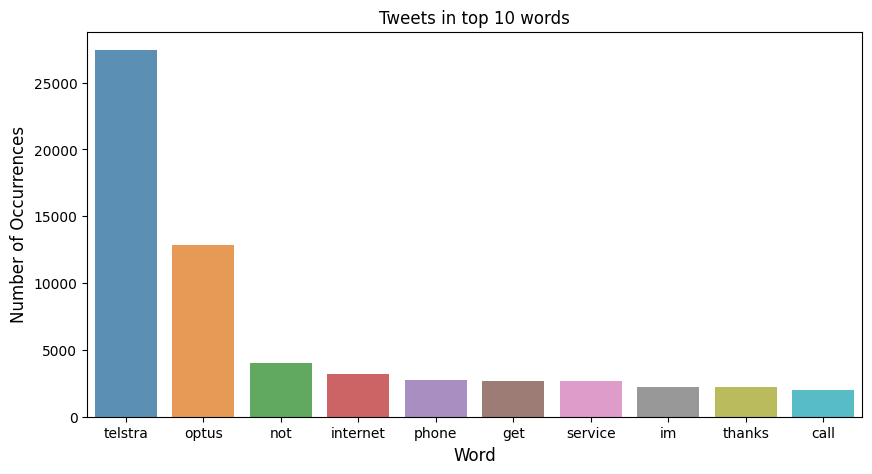

In [64]:
# Visualize the top word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(x=word_count.index, y=word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

In [65]:
from PIL import Image
from wordcloud import WordCloud

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


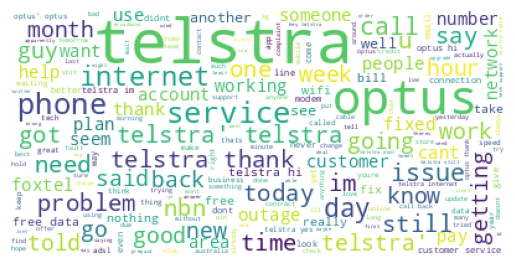

In [66]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Insight**  
From the word cloud we could identify that terms telstra and optus has been mentioned frequently. But this is expected - not so much an insight. Therefore, you may remove high frequent yet non-insightful words alongside the twitter specific words.

### Remove common words

Let's  remove context specific words and the most common words from the tweets.

The tweets extracted are from the hashtags @telstra and @optus, these keywords will appear in most tweets. Let's  add those keywords to the set of words to be removed.  
We can extend the new_words list with those additional keywords, which you may think will be widely used due to the area/domain the tweets were extracted.

In [67]:
# Creating a list of custom stopwords
new_words_to_remove = ["pic", "twitter", "com", "telstra", "optus"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# Remove common words
# We will use lambda function here.
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider,content_stem
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run
1,2016-01-01,,telstra,telstra
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...


Exercise: try to replicate lambda function above as a python function.

We will re-attempt to compose a frequency appearing word list.

In [69]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


not         3994
internet    3190
phone       2775
get         2668
service     2641
im          2258
thanks      2210
call        1992
still       1968
data        1761
dtype: int64

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


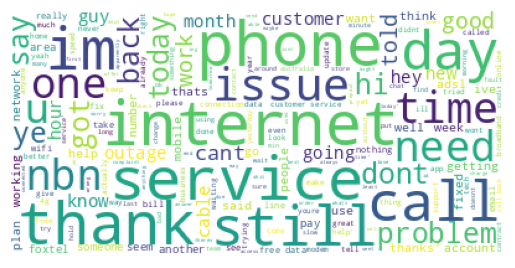

In [71]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bigrams and Trigrams

The following commands will extract bigrams from the tweet dataset.  
From here onwards, we will isolate tweets for each provider to conduct a comparative analysis.

In [72]:
# Seperate the two datasets by using pandas filtering mechanism.
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Bigrams

We will use CountVectorizer object from sklearn to generate bi-grams and tri-grams. [Link to API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  

You may refer [this StackoverFlow explanation](https://stackoverflow.com/questions/24005762/understanding-the-ngram-range-argument-in-a-countvectorizer-in-sklearn) to understand ngram_range parameter.

In [73]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Try out an example to see how this  function works.

In [74]:
txts = ['John likes to watch movies', 'Mary likes movies too', 'Mary also likes to watch football games']
get_ngrams(txts, ngram_range=(4, 4))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('john likes to watch', 1),
 ('likes to watch movies', 1),
 ('mary likes movies too', 1),
 ('mary also likes to', 1),
 ('also likes to watch', 1),
 ('likes to watch football', 1),
 ('to watch football games', 1)]

In [75]:
bigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(2, 2))
bigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(2, 2))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
bigrams_telstra

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('free data', 441),
 ('customer service', 275),
 ('call back', 186),
 ('not working', 182),
 ('im not', 179),
 ('data day', 136),
 ('still waiting', 131),
 ('still not', 128),
 ('mobile data', 125),
 ('cable internet', 117),
 ('phone line', 116),
 ('call centre', 115),
 ('home phone', 101),
 ('dont know', 97),
 ('internet connection', 93),
 ('tech support', 93),
 ('live chat', 91),
 ('cant get', 89),
 ('looks like', 88),
 ('case manager', 88),
 ('not sure', 88),
 ('new phone', 84),
 ('24 hours', 82),
 ('not good', 82),
 ('last week', 82),
 ('service status', 81),
 ('cant even', 81),
 ('last night', 78),
 ('internet service', 74),
 ('whats going', 74),
 ('not happy', 73),
 ('phone calls', 67),
 ('doesnt work', 65),
 ('not even', 64),
 ('reference number', 63),
 ('dont want', 63),
 ('phone call', 60),
 ('data today', 60),
 ('im still', 58),
 ('status page', 57),
 ('phone internet', 57),
 ('isnt working', 57),
 ('new modem', 54),
 ('get free', 54),
 ('trying get', 54),
 ('unlimited data'

Convert bigrams of both datasets to a dataframe with column names bi-gram and frequency.

In [77]:
bigrams_telstra_df = pd.DataFrame(bigrams_telstra)
bigrams_telstra_df.columns=["Bi-gram", "Freq"]

bigrams_optus_df = pd.DataFrame(bigrams_optus)
bigrams_optus_df.columns=["Bi-gram", "Freq"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


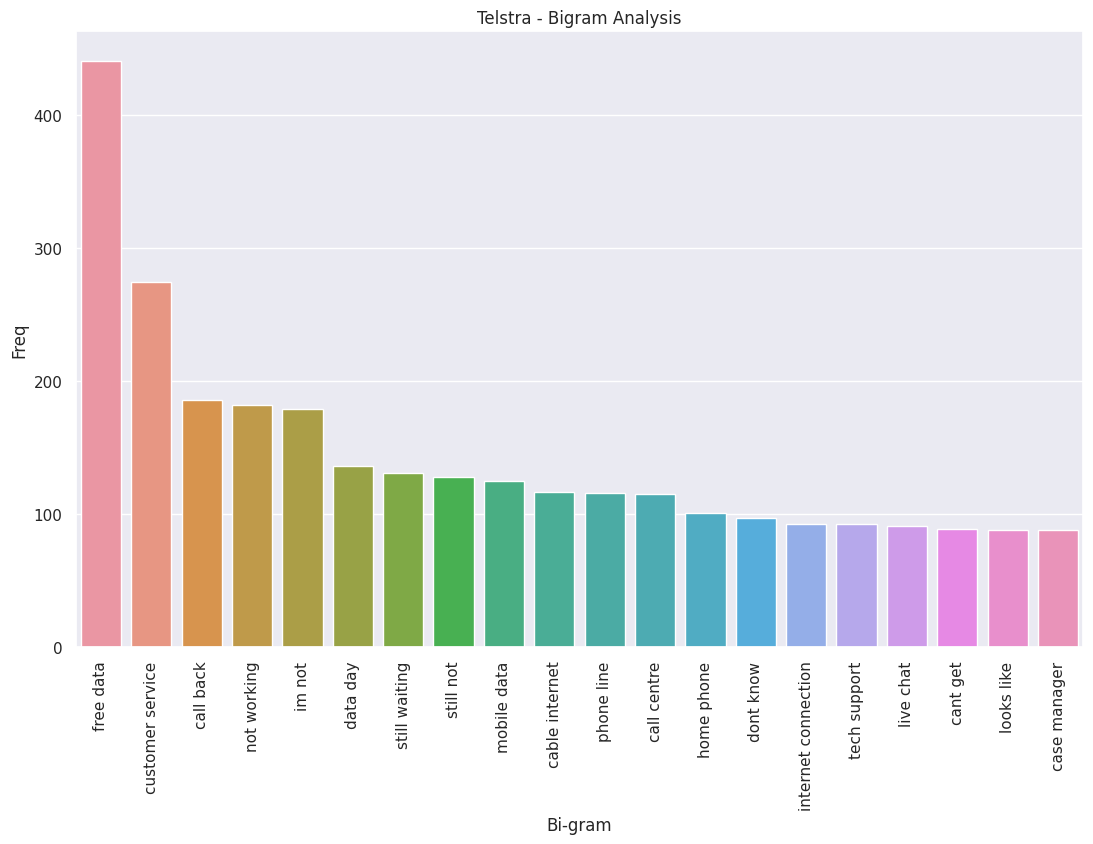

In [78]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_telstra_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Telstra - Bigram Analysis')
plt.show()

**Insights**:  
The bigram 'data day' refers to an event. After a series of outages, Telstra declared a free data day as a compensation. Notice how bigrams can be used to detect such events as well as topics/themes specific to the domain.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


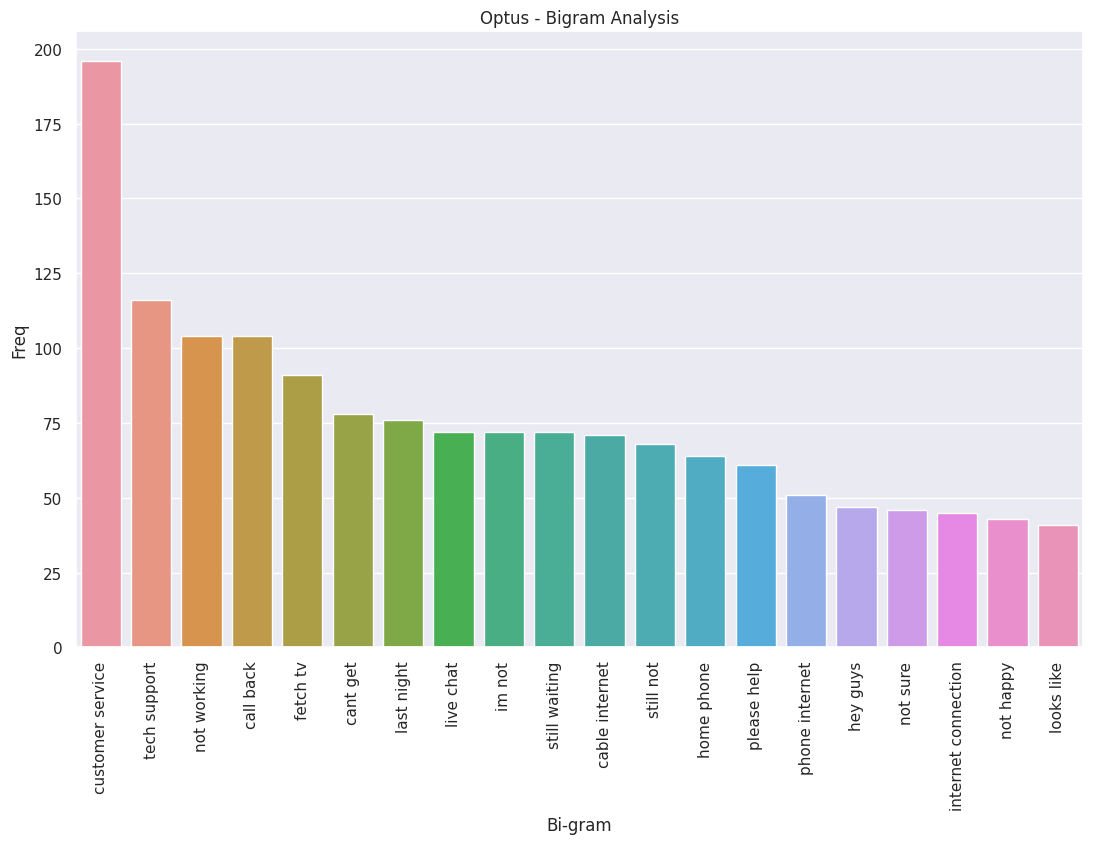

In [79]:
# Barplot of most freq Bi-grams for optus
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_optus_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Optus - Bigram Analysis')
plt.show()

**Insights:**  
Observe that in Optus dataset, there are many words related to sport which were not prominent in Telstra data. Bigram frequencies can be used to differentiate and compare topics of interest.

### Trigrams

Let's now attempt trigrams. 

In [80]:
trigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(3, 3))
trigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(3, 3))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Convert tri-grams of both datasets to a dataframe with column names tri-gram and frequency.

In [81]:
trigrams_telstra_df = pd.DataFrame(trigrams_telstra)
trigrams_telstra_df.columns=["Tri-gram", "Freq"]

trigrams_optus_df = pd.DataFrame(trigrams_optus)
trigrams_optus_df.columns=["Tri-gram", "Freq"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


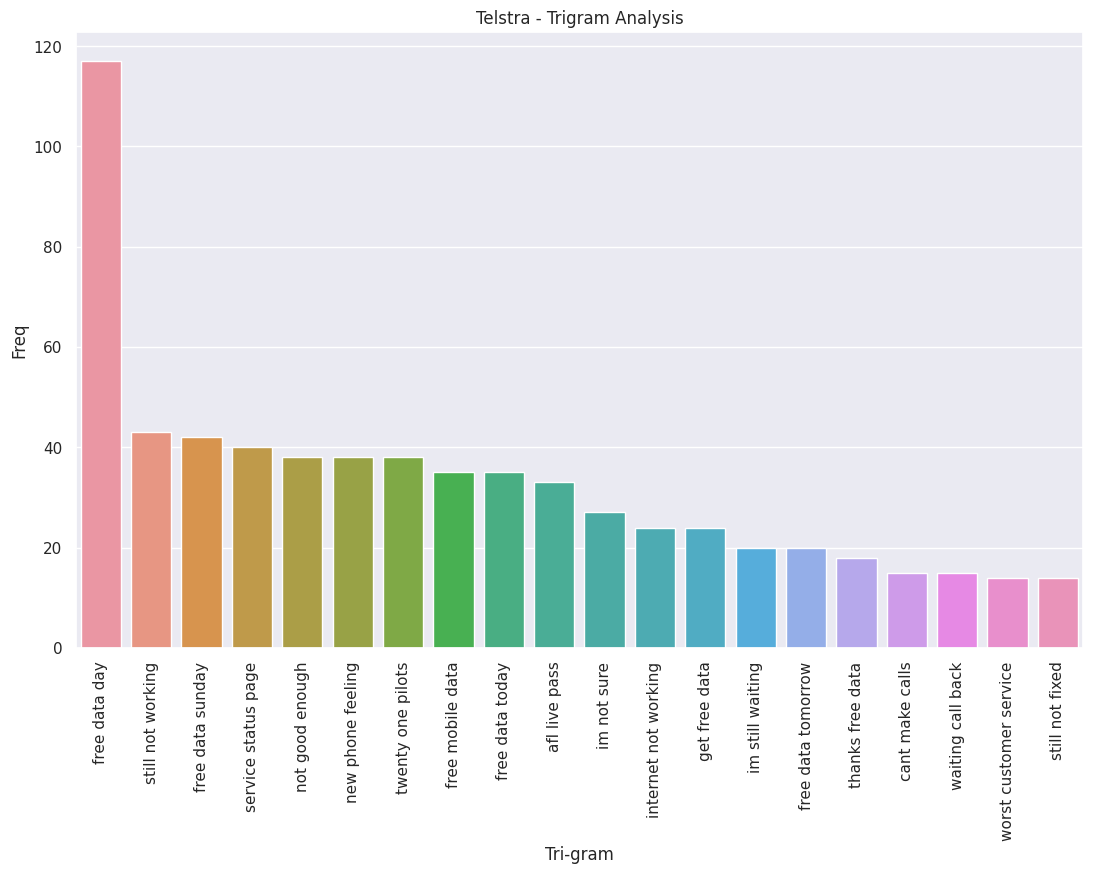

In [82]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_telstra_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Telstra - Trigram Analysis')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


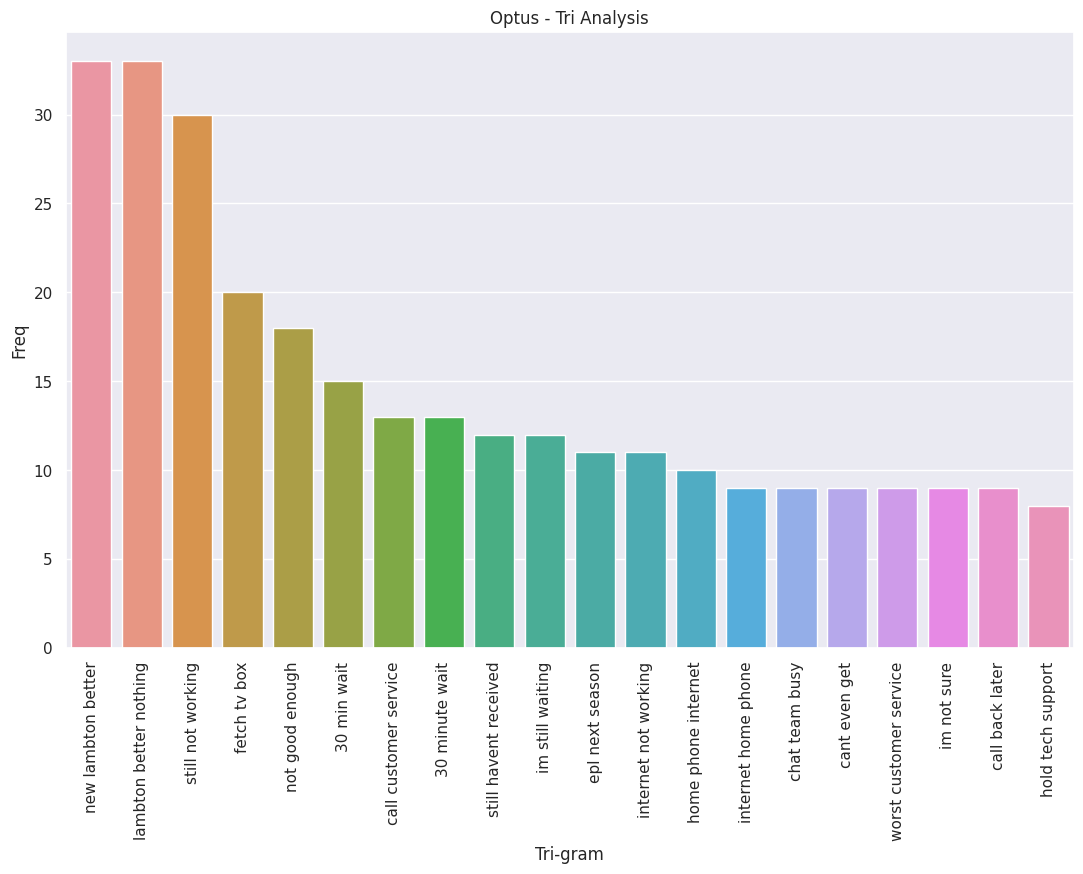

In [83]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_optus_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Optus - Tri Analysis')
plt.show()

Can you determine new insights from Trigram plots?

## Temporal Analysis

Now let's attempt to explore temporal patterns in the two datasets.

In [84]:
# Group the twitter datasets based on the date field and get the count per each day.
df_telstra_date_wise = df_telstra_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_telstra').set_index('day')
df_optus_date_wise = df_optus_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_optus').set_index('day')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
df_telstra_date_wise.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_count_telstra
day,
2016-01-01,147
2016-01-02,518
2016-01-03,418
2016-01-04,696
2016-01-05,257


In [86]:
df_optus_date_wise.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet_count_optus
day,
2016-02-25,160
2016-02-26,220
2016-02-27,140
2016-02-28,100
2016-02-29,155


When plotting with python, we can change the size of the plot and save it as a figure in your workspace.  
* Change size: plt.figure(figsize=(width, length)) # width and length are in inches  
* Save the image: plt.savefig(filename, dpi)  # dpi is the resolution in pixels

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:662: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


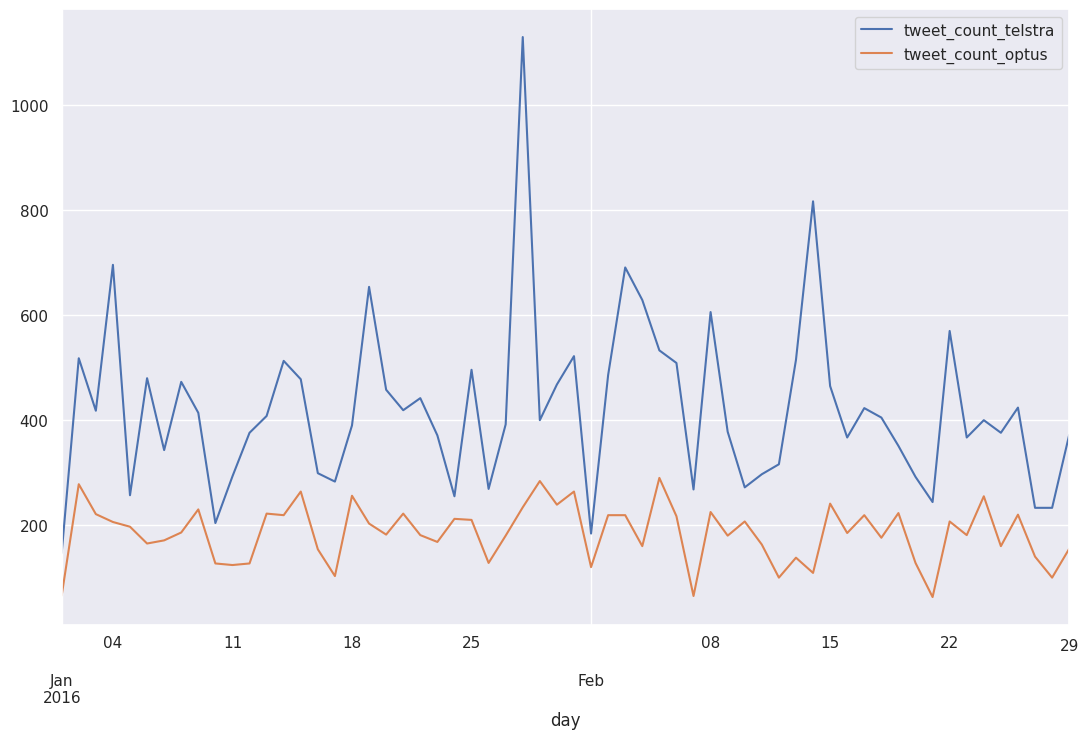

In [87]:
ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v2.png', dpi=800)

Output image is saved in files tab. You can right click on the image and download it to your computer for further analysis.

Insights: How would you describe the two line plots? Any actionable insights?  
Exerciese: Go through the actual Telstra dataset on 2018-01-28, can you explain this spike in tweet count?

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:662: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:662: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


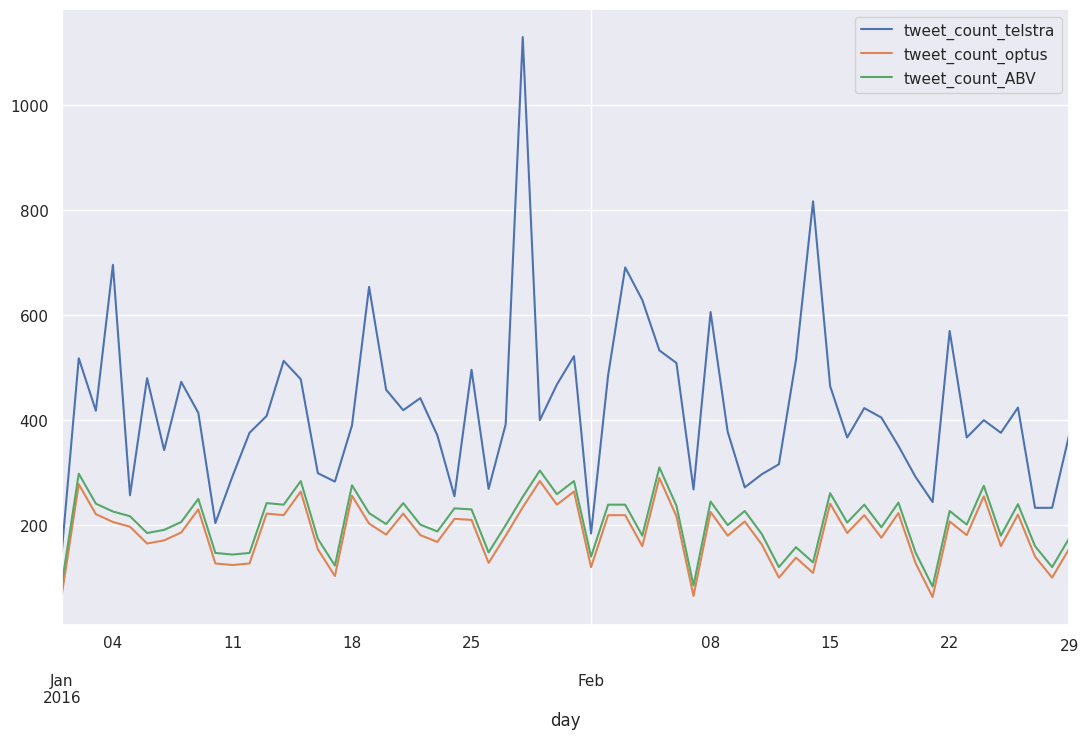

In [88]:
# this is a helper code if you have 3 or more dataframes to compare with.
df_ABC_date_wise =df_optus_date_wise.copy()
df_ABC_date_wise['tweet_count_ABV'] = df_ABC_date_wise['tweet_count_optus'] + 20
del df_ABC_date_wise['tweet_count_optus']

ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
df_ABC_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v3.png', dpi=800)

## Sentiment Analysis

Analyse sentiments for each tweet, aggregate into the sentiment of particular day and derive a sentiment timeline.

In [89]:
# Extract sentiments from the tweets (This should take some time because we run this to the entire dataset.)
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# Display first 50 tweets with respective sentiment value
df[['content', 'sentiment']].head(50)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,sentiment
0,runkeeper went run,0.000000
1,,0.000000
2,voice service least mon box door still open,-0.150000
3,home internet since yesterday says fixed 6pm 4...,0.100000
4,three times said error porting said completed ...,0.000000
5,last six weeks ed continually porting number a...,0.000000
6,already,0.000000
7,per tweet service restored 6pm 4th jan ridiculous,-0.333333
8,bilis nang hahahaha,0.200000
9,awesome thanks nye text im worried im missing ...,0.220000


Again we will conduct invididual analysis for both telcom providers.

In [91]:
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Aggregate the sentiment value (using mean) for each provider

In [92]:
df_telstra_processed

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,day,content,provider,content_stem,sentiment
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run,0.000
1,2016-01-01,,telstra,telstra,0.000
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open,-0.150
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...,0.100
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...,0.000
...,...,...,...,...,...
25567,2016-02-29,stop mobile redirecting home phone windows pho...,telstra,telstra stop mobil redirect home phone window ...,0.000
25568,2016-02-29,gg ed thegmunay,telstra,gg telstra ed thegmunay,0.000
25569,2016-02-29,get shit together ffs twice today internet died,telstra,telstra get shit togeth ff twice today interne...,-0.200
25570,2016-02-29,yeh technical error explanation told one date ...,telstra,telstra yeh technic error explan told one date...,0.125


In [93]:
df_telstra_processed.groupby(['day'])['sentiment'].mean()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


day
2016-01-01    0.003838
2016-01-02    0.028647
2016-01-03    0.066871
2016-01-04    0.043939
2016-01-05    0.032759
2016-01-06    0.009095
2016-01-07    0.016708
2016-01-08    0.031807
2016-01-09    0.038777
2016-01-10    0.060581
2016-01-11    0.034409
2016-01-12    0.013710
2016-01-13    0.010740
2016-01-14    0.021275
2016-01-15    0.012664
2016-01-16    0.038314
2016-01-17   -0.003051
2016-01-18    0.046497
2016-01-19    0.033564
2016-01-20    0.037302
2016-01-21    0.058624
2016-01-22    0.031233
2016-01-23    0.054891
2016-01-24    0.005957
2016-01-25    0.031732
2016-01-26    0.034476
2016-01-27    0.026120
2016-01-28    0.064812
2016-01-29    0.045313
2016-01-30    0.014393
2016-01-31    0.016682
2016-02-01    0.010754
2016-02-02    0.015110
2016-02-03    0.047731
2016-02-04    0.042135
2016-02-05    0.010857
2016-02-06    0.034101
2016-02-07    0.034366
2016-02-08    0.012498
2016-02-09    0.023839
2016-02-10    0.062685
2016-02-11    0.017418
2016-02-12    0.024969
2016-02

In [94]:
df_senti_telstra_date_wise = df_telstra_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_telstra').set_index('day')
df_senti_optus_date_wise = df_optus_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_optus').set_index('day')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot sentiment over time.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:662: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


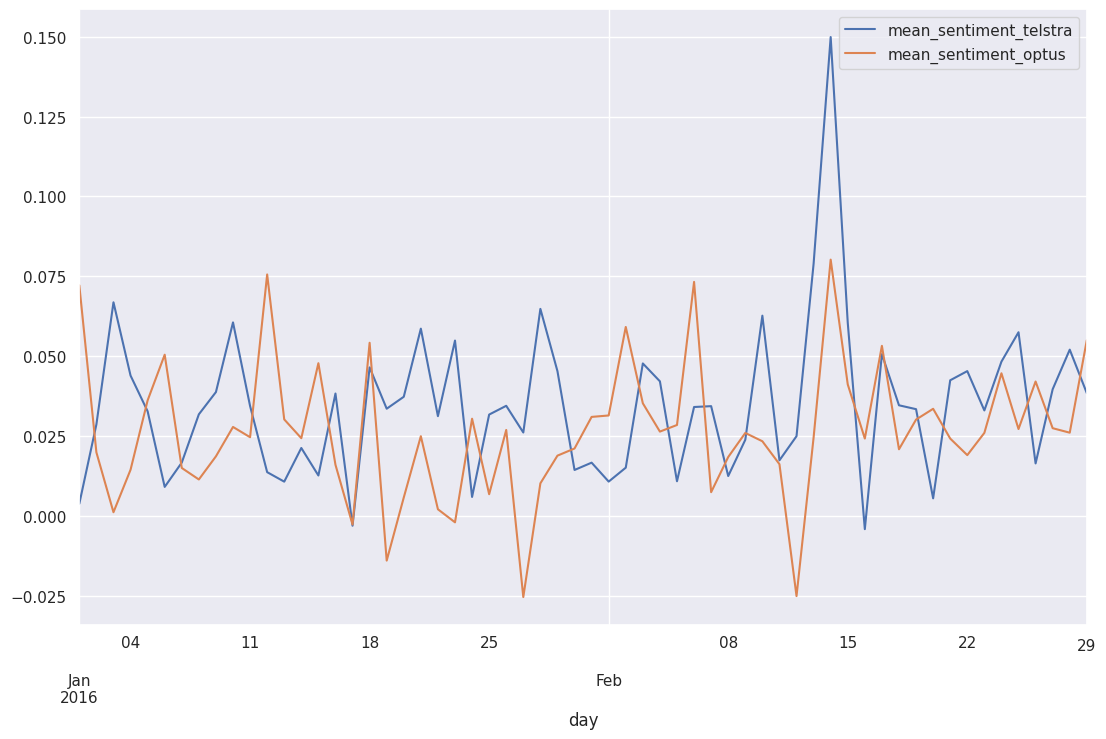

In [95]:
# Plot twitter sentimet timeline over each provider
ax = df_senti_telstra_date_wise.plot()
df_senti_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_sentiment_v2.png', dpi=800)

**Insights:**   
When deriving insights you can refer to days with significant sentiment scores (peaks) and explore the tweets to identify what event has led to positive/negative sentiment.

## Topic Modeling

We will conduct a topic modeling for one of the twitter datasets here (Telstra).  
It is possible to conduct topic modeling using single words, bigrams, trigrams or n-grams.  
Will be using a topic modeling algorithm named - LDA (Latent Dirichlet Allocation) for this task. 

In [96]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
# Filter the dataset of the telstra only.
df_telstra_processed = df.loc[df['provider'] == 'telstra']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we will create the text corpus.  


In [98]:
# Convert the tweets as the text corpus.
corpus = list(df_telstra_processed['content'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
corpus[:5]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['runkeeper went run',
 '',
 'voice service least mon box door still open',
 'home internet since yesterday says fixed 6pm 4jan five days areyoujoking pleaseexplain',
 'three times said error porting said completed wasnt cancelled']

In [100]:
# Tokenization
telstra_texts = [[word for word in str(document).split()] for document in corpus]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
telstra_texts[:5]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['runkeeper', 'went', 'run'],
 [],
 ['voice', 'service', 'least', 'mon', 'box', 'door', 'still', 'open'],
 ['home',
  'internet',
  'since',
  'yesterday',
  'says',
  'fixed',
  '6pm',
  '4jan',
  'five',
  'days',
  'areyoujoking',
  'pleaseexplain'],
 ['three',
  'times',
  'said',
  'error',
  'porting',
  'said',
  'completed',
  'wasnt',
  'cancelled']]

In [102]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(telstra_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'telstra.dict'))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


When creating the dictionary, each tweet (document) is alphabetically sorted before composing the dictionary.

In [103]:
print(telstra_texts[0])
print('alphabetically sorted', sorted(telstra_texts[0]))

['runkeeper', 'went', 'run']
alphabetically sorted ['run', 'runkeeper', 'went']


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
print(telstra_texts[1])
print('alphabetically sorted', sorted(telstra_texts[1]))

[]
alphabetically sorted []


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
# Print the dictionary
print(dictionary.token2id)

{'run': 0, 'runkeeper': 1, 'went': 2, 'box': 3, 'door': 4, 'least': 5, 'mon': 6, 'open': 7, 'service': 8, 'still': 9, 'voice': 10, '4jan': 11, '6pm': 12, 'areyoujoking': 13, 'days': 14, 'five': 15, 'fixed': 16, 'home': 17, 'internet': 18, 'pleaseexplain': 19, 'says': 20, 'since': 21, 'yesterday': 22, 'cancelled': 23, 'completed': 24, 'error': 25, 'porting': 26, 'said': 27, 'three': 28, 'times': 29, 'wasnt': 30, 'amaysim': 31, 'continually': 32, 'ed': 33, 'joke': 34, 'last': 35, 'number': 36, 'six': 37, 'weeks': 38, 'already': 39, '4th': 40, 'jan': 41, 'per': 42, 'restored': 43, 'ridiculous': 44, 'tweet': 45, 'bilis': 46, 'hahahaha': 47, 'nang': 48, 'awesome': 49, 'friends': 50, 'future': 51, 'get': 52, 'im': 53, 'missing': 54, 'nye': 55, 'offers': 56, 'text': 57, 'thanks': 58, 'worried': 59, 'bigpond': 60, 'bill': 61, 'charged': 62, 'double': 63, 'find': 64, 'ill': 65, 'movie': 66, 'next': 67, '24': 68, 'gone': 69, 'hit': 70, 'hours': 71, 'long': 72, 'something': 73, 'take': 74, 'trans

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in telstra_texts]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Can you explain this output?

In [107]:
tweet_id = 0
print(telstra_texts[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(telstra_texts[tweet_id])) # each token is represented as a id from a dictionary

['runkeeper', 'went', 'run']
[(0, 1), (1, 1), (2, 1)]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Generate the topic model

Recall we initially loaded models library from gensim.  
(from gensim import corpora, models, similarities)

In [108]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus] 

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We need to define how many topics we capture through LDA.

In [110]:
total_topics = 40

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below code will build the LDA topic model.   
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.



In [111]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.  
You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.





In [112]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.045*"broadband" + 0.045*"fault" + 0.039*"told" + 0.035*"went" + 0.031*"cheers" + 0.030*"shop"'),
 (1,
  '0.050*"wait" + 0.045*"sure" + 0.036*"minutes" + 0.032*"hold" + 0.031*"every" + 0.028*"not"'),
 (2,
  '0.061*"tell" + 0.050*"better" + 0.036*"network" + 0.035*"nbn" + 0.031*"copper" + 0.028*"sydney"'),
 (3,
  '0.059*"afl" + 0.044*"keep" + 0.041*"understand" + 0.041*"ang" + 0.034*"spent" + 0.030*"pass"'),
 (4,
  '0.074*"foxtel" + 0.053*"nothing" + 0.051*"account" + 0.037*"using" + 0.035*"email" + 0.034*"bigpond"'),
 (5,
  '0.138*"data" + 0.091*"free" + 0.063*"mobile" + 0.036*"month" + 0.035*"day" + 0.027*"calls"'),
 (6,
  '0.098*"customer" + 0.086*"service" + 0.077*"number" + 0.038*"contact" + 0.037*"australia" + 0.029*"may"'),
 (7,
  '0.071*"even" + 0.058*"chat" + 0.050*"tomorrow" + 0.043*"live" + 0.033*"say" + 0.031*"not"'),
 (8,
  '0.051*"code" + 0.043*"love" + 0.026*"set" + 0.024*"charge" + 0.023*"supposed" + 0.022*"within"'),
 (9,
  '0.056*"first" + 0.043*"oh" + 0.038*"

How will you interpret this?  
Assume a topic is a represented as '0.020*"nbn" + 0.010*"thanks" + 0.009*"turnbullmalcolm" + 0.009*"mobile" + 0.009*"copper" + 0.008*"buy"'  
  
It means the top 6 keywords that contribute to this topic are: nbn, thanks, turnbullmalcolm, mobile, copper, buy and the weight of ‘nbn’ on topic 5 is 0.020.  
  
The weights reflect how important a keyword is to that topic.  

Looking at these keywords, can you guess what this topic could be? You may summarise it as nbn connectivity (or more specifically Turnbull's decision as Telecommunications Minister to continue using the copper network for the NBN).  

Likewise, can you go through the remaining keyword subsets and infer each topic?  







### Interactive topic analyzer

In [113]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=               x         y  topics  cluster      Freq
topic                                                
36     -9.847517 -0.133460       1        1  5.175864
17    -10.347216  0.373891       2        1  5.106710
24     -9.510630 -0.950808       3        1  4.966988
6     -10.883442  0.337090       4        1  4.797949
34     -9.747794  0.625831       5        1  4.255010
10    -10.012722  0.666253       6        1  4.242546
21    -10.830399 -0.154200       7        1  3.824914
2      -9.710082  0.368467       8        1  3.715154
29    -10.603497 -0.165548       9        1  3.508781
30    -10.537598 -0.031885      10        1  3.377346
16    -10.145411 -0.479432      11        1  2.976501
0     -10.161102  0.707893      12        1  2.839555
5     -10.804525 -0.749111      13        1  2.809508
28    -10.080883  0.138832      14        1  2.672549
31     -9.599513 -1.122173      15        1  2.659257
9      -9.704697  0.316901      16        1  2.609255
38    -11.230403 -0.514801      17        1  2.590125
11    -10.177408 -0.666929      18        1  2.436351
14    -10.491180 -0.416019      19        1  2.241177
1     -10.660871 -0.110503      20        1  1.660298
12    -10.577967  0.088745      21        1  1.634005
33     -9.527848 -0.476372      22        1  1.573693
27     -9.933152 -0.748404      23        1  1.573693
32    -10.104491 -1.178376      24        1  1.573693
35     -9.540284  0.340921      25        1  1.573693
37     -9.072733 -0.786961      26        1  1.573693
20    -10.190264  1.142572      27        1  1.573693
26    -10.178976 -0.570560      28        1  1.573693
25     -9.207885  1.097898      29        1  1.573693
23     -9.392948  0.391003      30        1  1.573693
22     -9.919232  0.083222      31        1  1.573693
19    -10.344984 -1.016648      32        1  1.573693
18    -10.392482 -0.387667      33        1  1.573693
15     -8.922602  0.088028      34        1  1.573693
13     -9.350863 -0.045163      35        1  1.573693
8      -9.771396 -0.222025      36        1  1.573693
7      -9.698248 -0.281898      37        1  1.573693
4     -10.826941  0.471008      38        1  1.573693
3      -8.864382  0.160048      39        1  1.573693
39    -10.735824 -0.943057      40        1  1.573693, topic_info=          Term        Freq       Total Category  logprob  loglift
427        one  106.000000  106.000000  Default  30.0000  30.0000
58      thanks  198.000000  198.000000  Default  29.0000  29.0000
647   customer  102.000000  102.000000  Default  28.0000  28.0000
234       call   89.000000   89.000000  Default  27.0000  27.0000
132       data   97.000000   97.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1067   morning    2.550482   28.041315  Topic40  -4.8426   1.7543
104        not    3.394983  270.377758  Topic40  -4.5566  -0.2258
117      phone    2.915230  168.473102  Topic40  -4.7089   0.0949
374       yeah    2.415738   36.645798  Topic40  -4.8969   1.4325
234       call    2.286640   89.981894  Topic40  -4.9518   0.4792

[1949 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3348     20  0.633676       0
820       3  0.036621       1
820       9  0.073242       1
820      19  0.732417       1
820      33  0.073242       1
...     ...       ...     ...
2279     22  1.042288     yyy
4089     10  0.916687    yyyy
3871     33  1.163232  yyyyyy
3430     30  1.116412      yz
2029     34  1.102160    zero

[3315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[37, 18, 25, 7, 35, 11, 22, 3, 30, 31, 17, 1, 6, 29, 32, 10, 39, 12, 15, 2, 13, 34, 28, 33, 36, 38, 21, 27, 26, 24, 23, 20, 19, 16, 14, 9, 8, 5, 4, 40])

What is the relevance matrix? (The slider on the right)  
Understand what it means and how it can be used to derive more relevant topics from [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

## References

1.   [LDA Topic Modeling](https://youtu.be/3mHy4OSyRf0)
2.   [Topic Modelling in Python - Tutorial](https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html)